### 网络组件的定义
首先创建线性全连接层、ReLU激活函数、SoftMax交叉熵损失函数的类方法，类方法中定义正向传播与反向传播的函数计算。

In [29]:
import numpy as np

# 线性全连接层
class Linear:
    def __init__(self,w,b):
        self.W=w
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
        
    def forward(self,x):
        self.x=x
        out=self.x.dot(self.W)+self.b
        return out
    
    def backward(self,dout):
        dx=dout.dot(self.W.T)
        self.dW=self.x.T.dot(dout)
        self.db=np.sum(dout,axis=0)
        return dx

# ReLU激活函数
class ReLU:
    def __init__(self):
        self.out=None
        
    def forward(self,x):
        mask=(x<=0)
        self.mask=mask
        out=x.copy()
        out[mask]=0
        return out
    
    def backward(self,dout):
        dout[self.mask]=0
        return dout
    
# SoftMax交叉熵损失函数
def softmax(x):
    if x.ndim==2:
        x=x.T
        x=x-np.max(x,axis=0)    # 防止溢出
        y=np.exp(x)/np.sum(np.exp(x),axis=0)
        return y.T
    
    x=x-np.max(x)
    y=np.exp(x)/np.sum(np.exp(x))
    return y
               
def cross_entropy_error(y, t):  # y为预测标签，t为真实标签
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t  = t.argmax(axis=1)

    return -np.sum(np.log(y[np.arange(y.shape[0]), t] + 1e-7)) / batch_size
               
class SoftMaxLoss:
    def __init__(self):
        self.loss=None
        self.y=None
        self.t=None
        
    def forward(self,x,t):  # y为预测标签，t为真实标签
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y,self.t)
        return self.loss
    
    def backward(self,dout=1):
        batchsize=self.t.shape[0]
        dx=(self.y-self.t)/batchsize
        return dx

### 网络结构搭建
创建双层神经网络的结构，网络结构为全连接层-ReLU激活-全连接层，超参数为输入维度、隐藏层大小、输出维度，待估参数为两个线性全连接层的四个参数向量。

In [30]:
from collections import OrderedDict

# 定义双层神经网络
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        # 初始化权重
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
        
        # 搭建各个层
        self.layers=OrderedDict()
        self.layers['Linear1']=Linear(self.params['W1'],self.params['b1'])
        self.layers['ReLU']=ReLU()
        self.layers['Linear2']=Linear(self.params['W2'],self.params['b2'])
        self.Loss=SoftMaxLoss()
    
    # 正向传播
    def predict(self,x):
        for layer in self.layers.values():
            x=layer.forward(x)
        return x
    
    def loss(self,x,t):  # y为预测标签，t为真实标签
        y=self.predict(x)
        return self.Loss.forward(y,t)    
    
    def accuracy(self,x,t):  # y为预测标签，t为真实标签
        y=self.predict(x)
        y=np.argmax(y,axis=1)    
        if t.ndim!=1:
            t=np.argmax(t,axis=1)
        accuracy=np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    # 梯度计算与反向传播
    def gradient(self,x,t):  # y为预测标签，t为真实标签
        self.loss(x,t)
        
        dout=1
        dout=self.Loss.backward(dout)
        layers=list(self.layers.values())
        layers.reverse()
        
        # 反向传播
        for layer in layers:
            dout=layer.backward(dout)
            
        grads={}
        grads['W1']=self.layers['Linear1'].dW
        grads['b1']=self.layers['Linear1'].db
        grads['W2']=self.layers['Linear2'].dW
        grads['b2']=self.layers['Linear2'].db
        
        return grads

### 模型训练
使用《深度学习入门：基于Python的理论与实现》一书的dataset文件库读入MNIST数据，超参数设定如下：输入维度为784，隐藏层大小为50，输出维度为10，每个batch为100个样本，每个epoch迭代10000次，采用梯度下降的方法进行参数迭代，梯度下降的学习率为0.1。

In [31]:
import os, sys

sys.path.append(os.pardir)
from dataset.mnist import load_mnist

# 读入数据
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10,)

# 训练的一些超参数
iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=max(iters_num/batch_size,1)    

# 采用mini-batch方法训练
for iter in range(iters_num):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    # 计算梯度
    grads=network.gradient(x_batch,t_batch)
    
    # 梯度下降法更新权重
    for key in ['W1','b1','W2','b2']:
        network.params[key]-=learning_rate*grads[key]
        
    # 损失计算
    loss=network.loss(x_batch,t_batch)
    train_loss.append(loss)
    
    if iter%iter_per_epoch==0:
        train_acc=network.accuracy(x_train,t_train)
        test_acc=network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

### 模型评价
训练的损失曲线

Text(0, 0.5, 'loss in train')

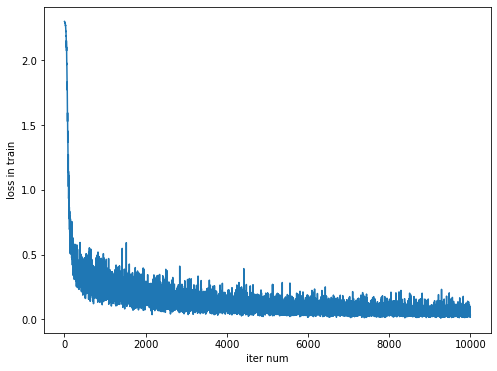

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(np.array(train_loss))
plt.xlabel('iter num')
plt.ylabel('loss in train')

训练的精度曲线

Text(0, 0.5, 'acc in train')

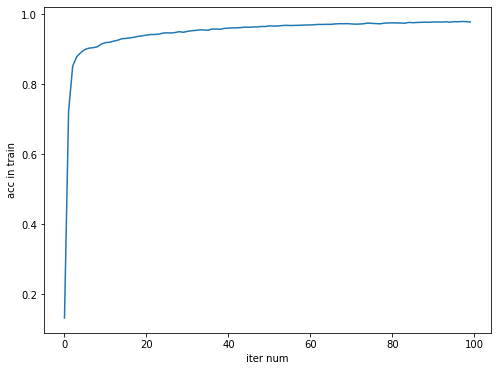

In [33]:
plt.figure(figsize=(8,6))
plt.plot(np.array(train_acc_list))
plt.xlabel('iter num')
plt.ylabel('acc in train')

测试的精度曲线

Text(0, 0.5, 'acc in test')

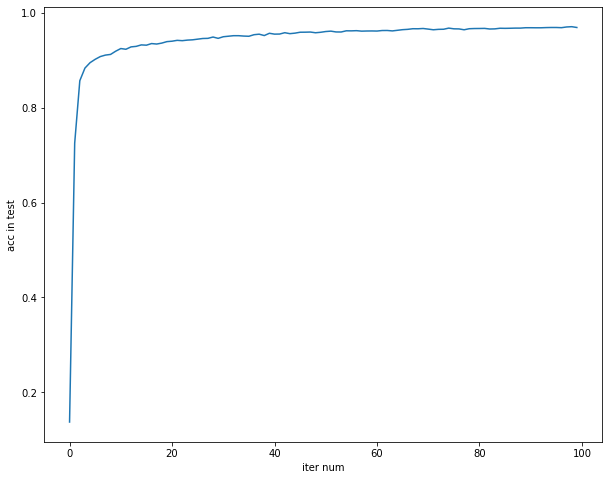

In [34]:
plt.figure(figsize=(10,8))
plt.plot(np.array(test_acc_list))
plt.xlabel('iter num')
plt.ylabel('acc in test')

测试集精度

In [35]:
network.accuracy(x_test, t_test)

0.9701

In [37]:
# 保存训练好的模型
import pickle
pickle.dump(network, open("TwoLayerNet.dat", "wb"))

百度网盘链接：https://pan.baidu.com/s/1-FO-KlOfyq5vv5MmR6hFmA?pwd=4tb1